# Data Exploration: Land surface temperature in Baltimore

In [14]:
import os 
dir_primary = 'F:/UrbanDataProject/land_surface_temperature/code/analysis'
# os.chdir('/home/tml/research/land_surface_temperature/code/analysis')
os.chdir(dir_primary)
from analysis import *
code_dir = os.getcwd()
os.chdir('../..')



# import libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
# from xgboost import XGBRegressor

RANDOM_SEED = 3201

In [46]:
grid_size = 500
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(grid_size)

# Describe

In [16]:
df.head()

,alb_max,alb_max_sl,alb_mean,alb_mean_sl,alb_min,alb_min_sl,alb_sd,alb_sd_sl,bldg,city,...,tree_max,tree_max_sl,tree_mean,tree_mean_sl,tree_min,tree_min_sl,tree_sd,tree_sd_sl,x,y
0,-0.354169,0.291607,-0.579427,-0.607351,-0.653830,-0.586822,-0.175151,0.062593,0.797467,bal,...,-0.004023,-0.604159,-0.489894,-0.637884,-0.048624,-0.06784,-0.284225,-0.656385,424996.178971,189212.211496
1,-0.513546,-0.312432,-0.660572,-0.721739,-0.550292,-0.669227,-0.407968,-0.303042,0.228484,bal,...,-0.004023,-0.340398,-0.530055,-0.593108,-0.048624,-0.06784,-0.320845,-0.449581,425496.178971,189212.211496
2,-0.937259,-0.906217,-0.812375,-0.769144,-0.661609,-0.692135,-0.684661,-0.739024,0.231592,bal,...,0.039183,0.354648,-0.552869,-0.510769,-0.048624,-0.06784,-0.395489,-0.137117,425996.178971,189212.211496
3,-0.957408,-0.915058,-0.613889,-0.800411,-0.628720,-0.755022,-0.713723,-0.694649,0.574349,bal,...,-0.004023,0.547122,-0.504370,-0.404118,-0.048624,-0.06784,-0.471948,0.203295,426496.178971,189212.211496
4,0.161978,-1.035540,-0.437111,-0.801640,-0.670724,-0.761732,-0.144113,-0.769281,-0.014751,bal,...,-0.004023,0.547122,-0.284177,-0.455074,-0.048624,-0.06784,0.139201,0.054371,426996.178971,189212.211496


In [17]:
# list of the variables
vars_all = df.columns.values
vars_all

array(['alb_max', 'alb_max_sl', 'alb_mean', 'alb_mean_sl', 'alb_min',
       'alb_min_sl', 'alb_sd', 'alb_sd_sl', 'bldg', 'city', 'dsm_max',
       'dsm_max_sl', 'dsm_mean', 'dsm_mean_sl', 'dsm_min', 'dsm_min_sl',
       'dsm_sd', 'dsm_sd_sl', 'elev_max', 'elev_max_sl', 'elev_mean',
       'elev_mean_sl', 'elev_min', 'elev_min_sl', 'elev_sd', 'elev_sd_sl',
       'holdout', 'lcov_11', 'lcov_11_sl', 'lst_day_mean',
       'lst_night_mean', 'nbdi_max', 'nbdi_max_sl', 'nbdi_mean',
       'nbdi_mean_sl', 'nbdi_min', 'nbdi_min_sl', 'nbdi_sd', 'nbdi_sd_sl',
       'ndvi_max', 'ndvi_max_sl', 'ndvi_mean', 'ndvi_mean_sl', 'ndvi_min',
       'ndvi_min_sl', 'ndvi_sd', 'ndvi_sd_sl', 'pdens_max', 'pdens_mean',
       'pdens_min', 'pdens_sd', 'svf_max', 'svf_max_sl', 'svf_mean',
       'svf_mean_sl', 'svf_min', 'svf_min_sl', 'svf_sd', 'svf_sd_sl',
       'tree_max', 'tree_max_sl', 'tree_mean', 'tree_mean_sl', 'tree_min',
       'tree_min_sl', 'tree_sd', 'tree_sd_sl', 'x', 'y'], dtype=object)

## Response

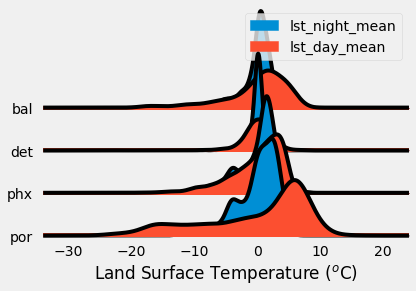

In [18]:
import joypy
df1 = df[['lst_night_mean','lst_day_mean','city']]
df1 = df1.rename(index=str, columns={"lst_night_mean_mean": "night", "lst_day_mean_mean": "day"})
df1 = df1.replace([np.inf, -np.inf], np.nan)
df1 = df1.dropna(axis=0, how='any')
with plt.style.context('fivethirtyeight'):
    fig, axes = joypy.joyplot(df1, by='city', ylim='own',legend=True)
    plt.xlabel('Land Surface Temperature ($^o$C)')

# Independent variables

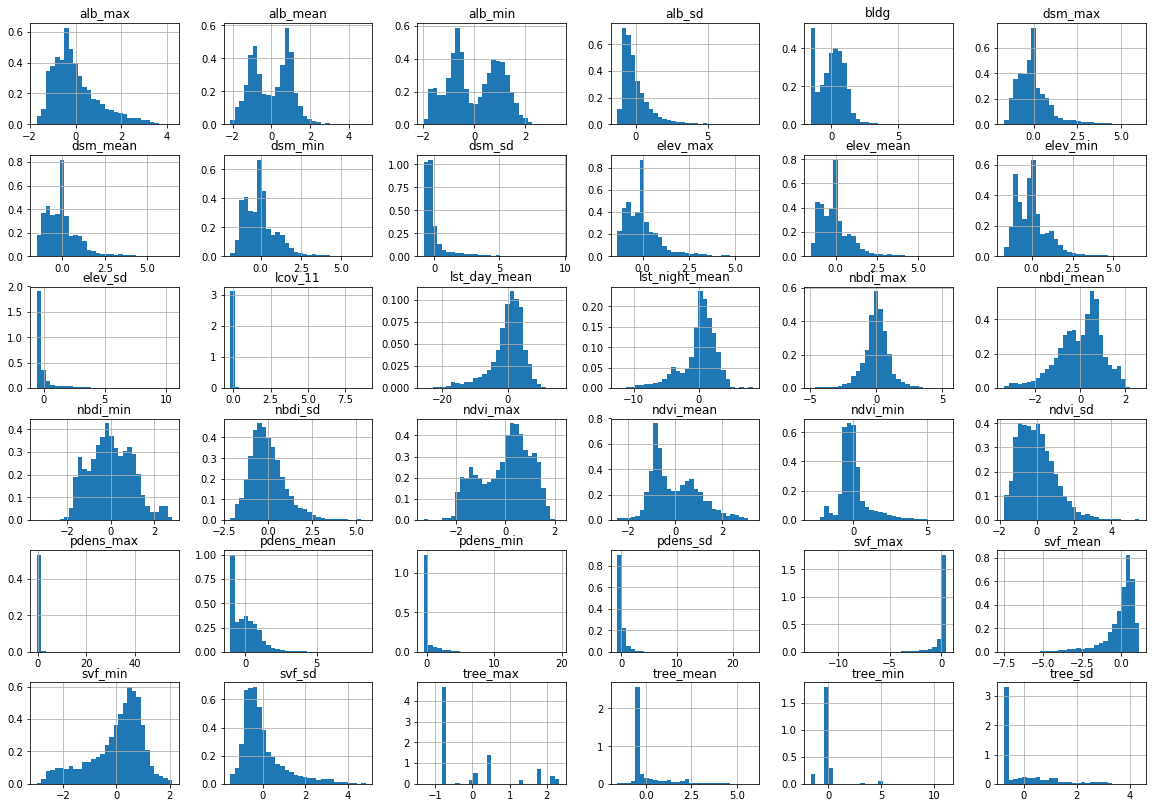

In [40]:
vars_plt = list(df.columns.values)
vars_plt = [x for x in vars_plt if x not in ['x','y','holdout']]
vars_plt = [x for x in vars_plt if 'sl' not in x]
df[vars_plt].hist(bins = 30, figsize=(20,14), density = True)
plt.show()

## Drop variables based on collinearity

In [43]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
df.columns

Index(['alb_max', 'alb_max_sl', 'alb_mean', 'alb_mean_sl', 'alb_min',
       'alb_min_sl', 'alb_sd', 'alb_sd_sl', 'bldg', 'dsm_max', 'dsm_max_sl',
       'dsm_mean', 'dsm_mean_sl', 'dsm_min', 'dsm_min_sl', 'dsm_sd',
       'dsm_sd_sl', 'elev_max', 'elev_max_sl', 'elev_mean', 'elev_mean_sl',
       'elev_min', 'elev_min_sl', 'elev_sd', 'elev_sd_sl', 'lcov_11',
       'lcov_11_sl', 'lst_day_mean', 'lst_night_mean', 'nbdi_max',
       'nbdi_max_sl', 'nbdi_mean', 'nbdi_mean_sl', 'nbdi_min', 'nbdi_min_sl',
       'nbdi_sd', 'nbdi_sd_sl', 'ndvi_max', 'ndvi_max_sl', 'ndvi_mean',
       'ndvi_mean_sl', 'ndvi_min', 'ndvi_min_sl', 'ndvi_sd', 'ndvi_sd_sl',
       'pdens_max', 'pdens_mean', 'pdens_min', 'pdens_sd', 'svf_max',
       'svf_max_sl', 'svf_mean', 'svf_mean_sl', 'svf_min', 'svf_min_sl',
       'svf_sd', 'svf_sd_sl', 'tree_max', 'tree_max_sl', 'tree_mean',
       'tree_mean_sl', 'tree_min', 'tree_min_sl', 'tree_sd', 'tree_sd_sl'],
      dtype='object')

In [77]:
# run a regression

#gather features
vars_reg = [x for x in df.columns.values if x not in ['x','y','holdout',"lst_day_mean", 'lst_night_mean']]

# loop until features with a vif > 10 are removed
vif_10 = True
while vif_10:
    features = "+".join(vars_reg)
    # get y and X dataframes based on this regression:
    y, X = dmatrices('lst_night_mean ~' + features, df, return_type='dataframe')
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    # is there a variable with vif > 10
    vif_10 = vif['VIF Factor'].max() > 5
    # remove the variable with the highest vif, if the vif is greater than 10
    if vif_10:
        var_remove = vif.loc[vif['VIF Factor'].idxmax(),'features']
        vars_reg.remove(var_remove)  
        print(var_remove)

elev_mean_sl
elev_mean
elev_min_sl
dsm_mean_sl
elev_max_sl
elev_min
elev_max
dsm_min
nbdi_mean_sl
svf_sd_sl
alb_mean_sl
dsm_sd_sl
nbdi_min_sl
dsm_max_sl
dsm_mean
ndvi_mean
dsm_sd
ndvi_mean_sl
ndvi_max_sl
alb_mean
svf_sd
alb_max_sl
svf_mean_sl
tree_sd_sl
nbdi_min
dsm_max
alb_min_sl
ndvi_sd_sl
nbdi_mean
elev_sd_sl
ndvi_sd
ndvi_min_sl
tree_mean_sl
alb_max
svf_mean
tree_sd
svf_min_sl


In [78]:
vif

,VIF Factor,features
0,1.000000,Intercept
1,4.303604,alb_min
2,2.343316,alb_sd
3,2.682635,alb_sd_sl
4,2.932268,bldg
5,1.774949,dsm_min_sl
6,3.435015,elev_sd
7,3.663702,lcov_11
8,3.946273,lcov_11_sl
9,3.798934,nbdi_max


# Explore correlations

In [80]:
corr_matrix = df[vars_reg].corr()
corr_matrix

,alb_min,alb_sd,alb_sd_sl,bldg,dsm_min_sl,elev_sd,lcov_11,lcov_11_sl,nbdi_max,nbdi_max_sl,...,pdens_min,pdens_sd,svf_max,svf_max_sl,svf_min,tree_max,tree_max_sl,tree_mean,tree_min,tree_min_sl
alb_min,1.000000,0.189527,0.319472,0.182669,-0.002691,-0.150840,-0.257295,-0.291561,0.426832,0.577298,...,0.071155,-0.025249,0.296282,0.380640,0.665310,0.083057,0.132424,0.198334,0.221260,0.251165
alb_sd,0.189527,1.000000,0.677874,0.300713,-0.258459,-0.211303,-0.020635,0.041390,0.433730,0.392653,...,-0.159864,0.035146,0.238415,0.262610,0.067111,-0.001903,-0.009623,-0.095618,-0.124767,-0.158577
alb_sd_sl,0.319472,0.677874,1.000000,0.277352,-0.366324,-0.283373,0.000313,0.018402,0.423513,0.547958,...,-0.117503,0.039730,0.275630,0.366362,0.155049,-0.007144,-0.001043,-0.121412,-0.153634,-0.209603
bldg,0.182669,0.300713,0.277352,1.000000,-0.104496,-0.361815,-0.237846,-0.227343,0.083655,0.068933,...,0.246986,0.347505,0.188920,0.218848,-0.035606,-0.437329,-0.441964,-0.512900,-0.115021,-0.181805
dsm_min_sl,-0.002691,-0.258459,-0.366324,-0.104496,1.000000,0.462460,-0.197202,-0.256472,-0.205064,-0.261511,...,0.028703,-0.085544,-0.314849,-0.417305,-0.114620,-0.085441,-0.101837,0.090263,0.319416,0.423043
elev_sd,-0.150840,-0.211303,-0.283373,-0.361815,0.462460,1.000000,-0.050709,-0.042133,-0.162710,-0.210590,...,-0.109587,-0.115680,-0.649181,-0.726285,-0.271309,0.163879,0.189909,0.371358,0.382622,0.471342
lcov_11,-0.257295,-0.020635,0.000313,-0.237846,-0.197202,-0.050709,1.000000,0.824621,-0.038428,-0.027575,...,-0.060409,-0.097327,0.056949,0.056457,-0.029970,0.075352,0.074927,-0.146282,-0.327674,-0.343026
lcov_11_sl,-0.291561,0.041390,0.018402,-0.227343,-0.256472,-0.042133,0.824621,1.000000,0.010276,-0.018872,...,-0.094660,-0.094816,0.059870,0.066037,-0.084123,0.088758,0.081407,-0.116766,-0.345835,-0.416528
nbdi_max,0.426832,0.433730,0.423513,0.083655,-0.205064,-0.162710,-0.038428,0.010276,1.000000,0.738745,...,-0.165357,-0.003606,0.300088,0.350818,0.401004,0.081773,0.092188,0.102897,0.034284,0.057473
nbdi_max_sl,0.577298,0.392653,0.547958,0.068933,-0.261511,-0.210590,-0.027575,-0.018872,0.738745,1.000000,...,-0.107829,-0.026346,0.345115,0.454733,0.539055,0.100825,0.122926,0.137723,0.070099,0.085047


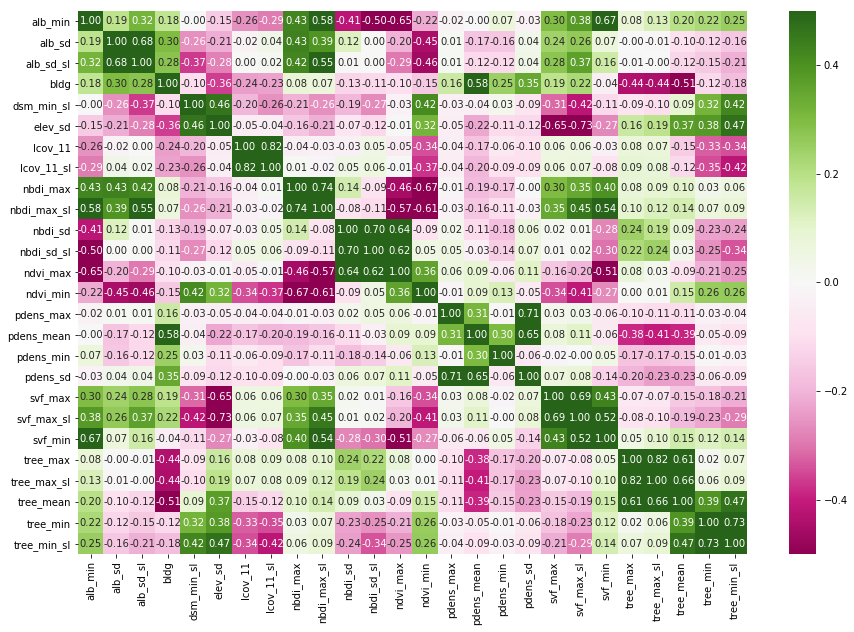

In [82]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, 
            cmap='PiYG',
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            vmin=-0.5,vmax=0.5,center=0, 
            annot = True, fmt='.2f')

# Initial Regressions

Doing some initial regression fitting to see how the models look and what the most important variables are.

In [86]:
# X_train, lst_day_train, lst_night_train, X_test
lst_day_train = df['lst_day_mean']
lst_night_train = df['lst_night_mean']
# X
X_train = df[vars_reg]


### Random Forest

In [87]:
# train the model
rf_day_reg = RandomForestRegressor(max_depth=2, random_state=RANDOM_SEED, n_estimators=500, max_features=1/3)
rf_night_reg = RandomForestRegressor(max_depth=2, random_state=RANDOM_SEED, n_estimators=500, max_features=1/3)
rf_day_reg.fit(X_train, lst_day_train)
rf_night_reg.fit(X_train, lst_night_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=0.3333333333333333, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=3201, verbose=0, warm_start=False)

#### Variable importance

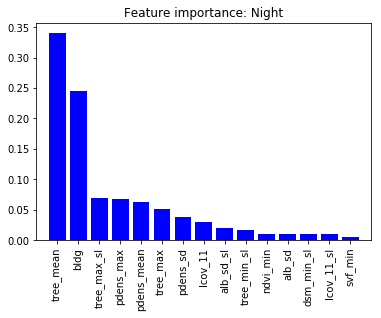

Feature ranking:
1. tree_mean (0.34025535419972613)
2. bldg (0.24558412878885483)
3. tree_max_sl (0.06937630702075641)
4. pdens_max (0.06847044597914993)
5. pdens_mean (0.06254631367038628)
6. tree_max (0.05046952854237648)
7. pdens_sd (0.03851530210809076)
8. lcov_11 (0.030080195485643852)
9. alb_sd_sl (0.019480555093601214)
10. tree_min_sl (0.01708808697120653)
11. ndvi_min (0.010543769752338112)
12. alb_sd (0.010374908919880525)
13. dsm_min_sl (0.009881329223280336)
14. lcov_11_sl (0.009557168509651505)
15. svf_min (0.005032982612179761)
16. nbdi_sd (0.004201800656177651)
17. alb_min (0.0028697498594498446)
18. svf_max (0.0020259749327689114)
19. tree_min (0.001790644953798182)
20. nbdi_sd_sl (0.0007580304846288506)
21. ndvi_max (0.000642846270091892)
22. svf_max_sl (0.00036317617085877694)
23. elev_sd (9.13997951034259e-05)
24. nbdi_max (0.0)
25. nbdi_max_sl (0.0)
26. pdens_min (0.0)


In [91]:
important_num = 15 # top five
importances = rf_night_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Night")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="b", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. {} ({})".format(f + 1, covariates[indices[f]], importances[indices[f]]))



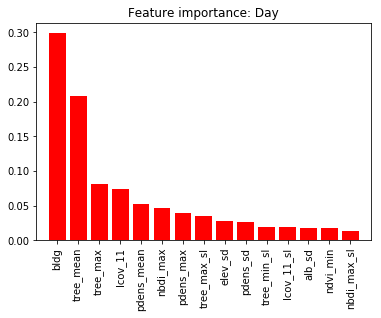

Feature ranking:
1. bldg (0.29868955300545386)
2. tree_mean (0.2084625728530261)
3. tree_max (0.08081703161738096)
4. lcov_11 (0.07371392482690853)
5. pdens_mean (0.052033640533307765)
6. nbdi_max (0.04633971605793182)
7. pdens_max (0.03897387585162252)
8. tree_max_sl (0.03436428437540749)
9. elev_sd (0.02698833274818095)
10. pdens_sd (0.02565494577520088)
11. tree_min_sl (0.018786904778772595)
12. lcov_11_sl (0.018580524062367654)
13. alb_sd (0.017947882318784417)
14. ndvi_min (0.017676345229887865)
15. nbdi_max_sl (0.013457852020067251)
16. alb_min (0.011720152771419834)
17. tree_min (0.003928530539292457)
18. ndvi_max (0.0031493442990524426)
19. alb_sd_sl (0.003055146445517056)
20. svf_min (0.002825264457776626)
21. nbdi_sd (0.0015380508920028108)
22. svf_max (0.0006926132121443932)
23. svf_max_sl (0.0006035113284939539)
24. nbdi_sd_sl (0.0)
25. pdens_min (0.0)
26. dsm_min_sl (0.0)


In [90]:
important_num = 15 # top five
importances = rf_day_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Day")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="r", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. {} ({})".format(f + 1, covariates[indices[f]], importances[indices[f]]))



Note:
* lcov_11 is the area of water in the grid cell
* lcov_23 is the area of developed, medium intensity in the cell (single-family housing units)
* alb = albedo 
* tree = tree canopy
* imp = impervious surface
* the _mean / _min / _max are the mean, min, or max of measurements within the cell from the averaged satellite images
* _sl means the average of the surrounding cells (i.e. spatially lagged variable)



### Gradient Boosted Regression Trees

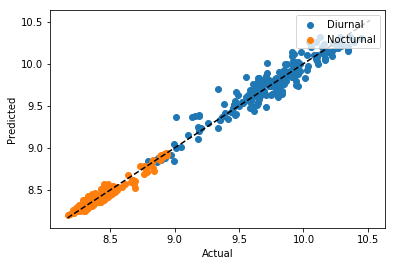

Nocturnal 
 MAE: 0.0301 
 Out-of-bag R^2: 0.92
Diurnal 
 MAE: 0.0790 
 Out-of-bag R^2: 0.95


In [28]:
# train the model
gbm_day_reg = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
gbm_night_reg = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
gbm_day_reg.fit(X_train, lst_day_train)
gbm_night_reg.fit(X_train, lst_night_train)

# predict the model
gbm_predict_day = gbm_day_reg.predict(X_test)
gbm_predict_night = gbm_night_reg.predict(X_test)

# plot predict vs actual
plt.scatter(lst_day_test, gbm_predict_day, label = 'Diurnal')
plt.scatter(lst_night_test, gbm_predict_night, label = 'Nocturnal')
plt.plot(xy_line,xy_line, 'k--')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(gbm_predict_day - lst_day_test))
mae_night = np.mean(abs(gbm_predict_night - lst_night_test))
print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_day_test, gbm_predict_day)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_night_test, gbm_predict_night)))

In [29]:
X_train.columns.values

array(['area', 'alb_mean_mean', 'alb_mean_max', 'alb_mean_min',
       'ndvi_mean_mean', 'ndvi_mean_max', 'ndvi_mean_min', 'lcov_11',
       'lcov_21', 'lcov_22', 'lcov_23', 'lcov_24', 'lcov_31', 'lcov_41',
       'lcov_42', 'lcov_43', 'lcov_52', 'lcov_71', 'lcov_90', 'lcov_95',
       'tree_mean', 'tree_max', 'tree_min', 'imp_mean', 'imp_max',
       'imp_min', 'alb_mean_mean_sl', 'alb_mean_max_sl',
       'alb_mean_min_sl', 'ndvi_mean_mean_sl', 'ndvi_mean_max_sl',
       'ndvi_mean_min_sl', 'lcov_11_sl', 'lcov_21_sl', 'lcov_22_sl',
       'lcov_23_sl', 'lcov_24_sl', 'lcov_31_sl', 'lcov_41_sl',
       'lcov_42_sl', 'lcov_43_sl', 'lcov_52_sl', 'lcov_71_sl',
       'lcov_90_sl', 'lcov_95_sl', 'tree_mean_sl', 'tree_max_sl',
       'tree_min_sl', 'imp_mean_sl', 'imp_max_sl', 'imp_min_sl'],
      dtype=object)

### XGBoost

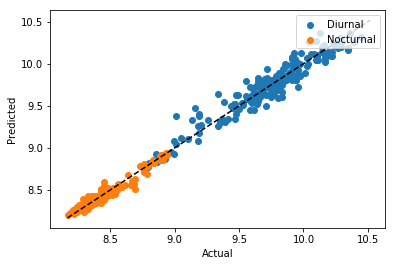

Nocturnal 
 MAE: 0.0297 
 Out-of-bag R^2: 0.92
Diurnal 
 MAE: 0.0787 
 Out-of-bag R^2: 0.95


In [30]:
# train the model
xgb_day_reg = XGBRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
xgb_night_reg = XGBRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
xgb_day_reg.fit(X_train, lst_day_train)
xgb_night_reg.fit(X_train, lst_night_train)

# predict the model
xgb_predict_day = xgb_day_reg.predict(X_test)
xgb_predict_night = xgb_night_reg.predict(X_test)

# plot predict vs actual
plt.scatter(lst_day_test, xgb_predict_day, label = 'Diurnal')
plt.scatter(lst_night_test, xgb_predict_night, label = 'Nocturnal')
plt.plot(xy_line,xy_line, 'k--')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(xgb_predict_day - lst_day_test))
mae_night = np.mean(abs(xgb_predict_night - lst_night_test))
print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_day_test, xgb_predict_day)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_night_test, xgb_predict_night)))

### Variable Importance

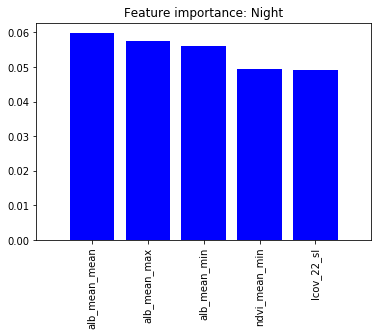

Feature ranking:
1. feature #1: alb_mean_mean (0.059811090534925476)
2. feature #2: alb_mean_max (0.05734840564910548)
3. feature #3: alb_mean_min (0.05618319692883692)
4. feature #6: ndvi_mean_min (0.04944806244662968)
5. feature #34: lcov_22_sl (0.04908998101088337)
6. feature #27: alb_mean_max_sl (0.04714984829341372)
7. feature #4: ndvi_mean_mean (0.04538972291661243)
8. feature #36: lcov_24_sl (0.044558340171461375)
9. feature #30: ndvi_mean_max_sl (0.042689199587965514)
10. feature #35: lcov_23_sl (0.03614343590926225)
11. feature #5: ndvi_mean_max (0.03347249563399021)
12. feature #31: ndvi_mean_min_sl (0.033096842428766565)
13. feature #10: lcov_23 (0.02919907671881191)
14. feature #8: lcov_21 (0.027733307101439453)
15. feature #28: alb_mean_min_sl (0.026341947050219354)
16. feature #11: lcov_24 (0.026214415729367283)
17. feature #26: alb_mean_mean_sl (0.024983683031642803)
18. feature #46: tree_max_sl (0.02453480665934047)
19. feature #29: ndvi_mean_mean_sl (0.0226661969299300

In [31]:
important_num = 5 # top five
importances = gbm_night_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Night")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="b", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. feature #{}: {} ({})".format(f + 1,indices[f], covariates[indices[f]], importances[indices[f]]))


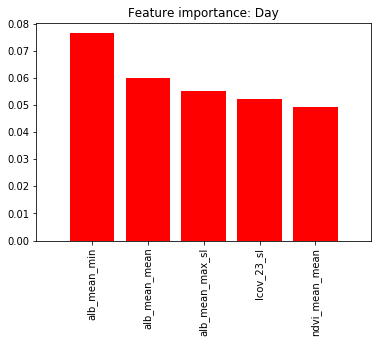

Feature ranking:
1. feature #3: alb_mean_min (0.07648063159996003)
2. feature #1: alb_mean_mean (0.06007794467399234)
3. feature #27: alb_mean_max_sl (0.055065115160562506)
4. feature #35: lcov_23_sl (0.05221337712660318)
5. feature #4: ndvi_mean_mean (0.049454696060995035)
6. feature #2: alb_mean_max (0.044587610611228186)
7. feature #26: alb_mean_mean_sl (0.04440488690755776)
8. feature #34: lcov_22_sl (0.03933983724550706)
9. feature #31: ndvi_mean_min_sl (0.03574804010596473)
10. feature #11: lcov_24 (0.03529201299398849)
11. feature #28: alb_mean_min_sl (0.03342532488674437)
12. feature #40: lcov_43_sl (0.032908724858467645)
13. feature #5: ndvi_mean_max (0.031973196511016024)
14. feature #9: lcov_22 (0.03140673902233054)
15. feature #6: ndvi_mean_min (0.031218604584426594)
16. feature #36: lcov_24_sl (0.02975067527923632)
17. feature #10: lcov_23 (0.02913456587838714)
18. feature #50: imp_min_sl (0.018230400154775252)
19. feature #20: tree_mean (0.01810030813215732)
20. feature #

In [32]:
important_num = 5 # top five
importances = gbm_day_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Day")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="r", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. feature #{}: {} ({})".format(f + 1,indices[f], covariates[indices[f]], importances[indices[f]]))



Note:
* lcov_11 is the area of water in the grid cell
* lcov_22 is low-intensity development. usually 20-49% impervious surface, with single-family housing.

### Partial Dependence

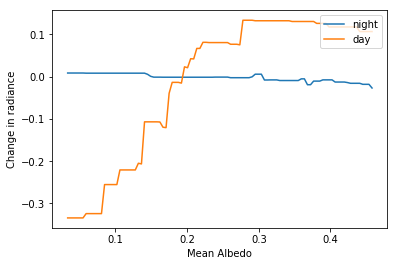

In [33]:
pdp_day = partial_dependence(gbm_day_reg, [1], X=X_train) 
pdp_night = partial_dependence(gbm_night_reg, [1], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Mean Albedo')
plt.legend(loc='upper right')
plt.show()

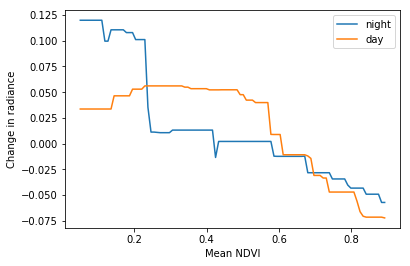

In [34]:
pdp_day = partial_dependence(gbm_day_reg, [4], X=X_train) 
pdp_night = partial_dependence(gbm_night_reg, [4], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Mean NDVI')
plt.legend(loc='upper right')
plt.show()

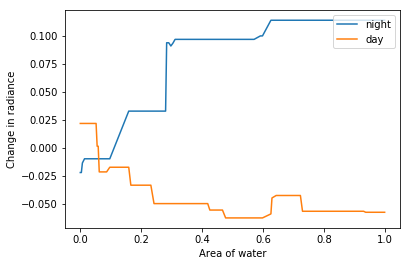

In [35]:
pdp_day = partial_dependence(gbm_day_reg, [7], X=X_train) 
pdp_night = partial_dependence(gbm_night_reg, [7], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Area of water')
plt.legend(loc='upper right')
plt.show()

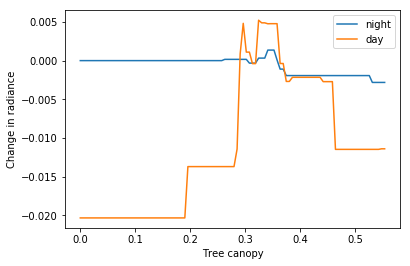

In [36]:
pdp_day = partial_dependence(gbm_day_reg, [20], X=X_train) 
pdp_night = partial_dependence(gbm_night_reg, [20], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Tree canopy')
plt.legend(loc='upper right')
plt.show()

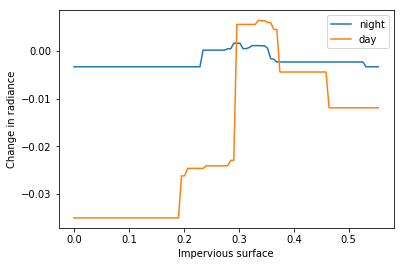

In [37]:
pdp_day = partial_dependence(gbm_day_reg, [23], X=X_train) 
pdp_night = partial_dependence(gbm_night_reg, [23], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Impervious surface')
plt.legend(loc='upper right')
plt.show()